In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/chexnet_hef.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/HEF/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/HEF/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

#### Keras Callbacks

In [3]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(chexnet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(chexnet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


### ChexNet Model Compile

In [5]:
#load pretrained efficientnet model fine-tuned on our dataset
from tensorflow import keras
chexnet_model = keras.models.load_model('./weights/chexnet_adam_dropout.hdf5')
chexnet_model.summary()

2022-08-16 15:49:22.822979: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-16 15:49:22.823040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7673 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
history = chexnet_model.fit(train_generator,
                            epochs=20,
                            validation_data=validation_generator,
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 1/20


2022-08-16 15:49:45.783284: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9561 - AUC: 0.9927 - precision: 0.9569 - recall: 0.9551
Epoch 00001: val_loss improved from inf to 0.51197, saving model to ./weights/chexnet_hef.hdf5
End of epoch 0. Learning rate: 1e-05
286/286 [==============================] - 131s 410ms/step - loss: 0.1459 - accuracy: 0.9561 - AUC: 0.9927 - precision: 0.9569 - recall: 0.9551 - val_loss: 0.5120 - val_accuracy: 0.8858 - val_AUC: 0.9619 - val_precision: 0.8878 - val_recall: 0.8844
Learning rate:  1e-05
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9608 - AUC: 0.9939 - precision: 0.9616 - recall: 0.9602
Epoch 00002: val_loss did not improve from 0.51197
End of epoch 1. Learning rate: 1e-05
286/286 [==============================] - 117s 408ms/step - loss: 0.1253 - accuracy: 0.9608 - AUC: 0.9939 - precision: 0.9616 - recall: 0.9602 - val_loss: 0.5483 - val_accuracy: 0.8775 - val_AUC: 0.9579 - val_precision: 0.878

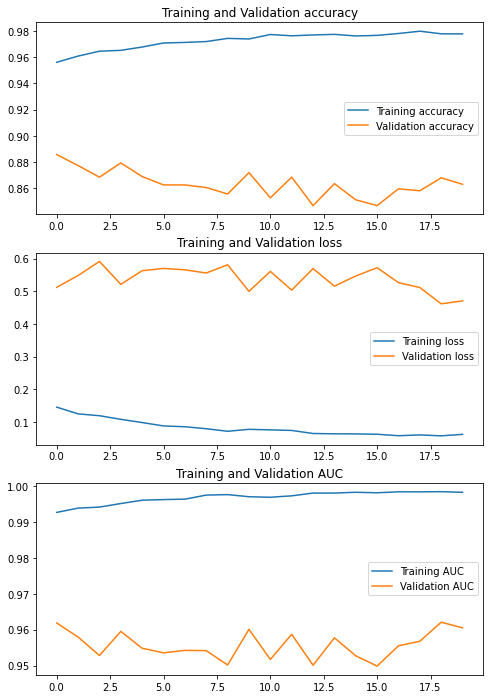

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall
epoch,,,,,,,,,,
18,0.058124,0.977766,0.998523,0.978399,0.977327,0.461737,0.868110,0.962097,0.868707,0.866142
19,0.062703,0.977656,0.998340,0.978075,0.977218,0.470648,0.863189,0.960523,0.864691,0.861713
9,0.078055,0.973823,0.997108,0.974345,0.973384,0.499857,0.872047,0.960115,0.874320,0.869587
11,0.074658,0.976232,0.997360,0.976535,0.975465,0.503472,0.868602,0.958716,0.870745,0.868602
17,0.060976,0.979737,0.998471,0.980162,0.979518,0.511481,0.858268,0.956780,0.859044,0.857776
0,0.145863,0.956079,0.992741,0.956875,0.955093,0.511974,0.885827,0.961888,0.887846,0.884350
13,0.064289,0.977327,0.998137,0.977858,0.977108,0.515600,0.863681,0.957733,0.864198,0.861220
3,0.108643,0.965170,0.995210,0.965566,0.964403,0.521265,0.879429,0.959532,0.880929,0.877461
16,0.058522,0.977985,0.998478,0.978621,0.977656,0.526412,0.859744,0.955517,0.859961,0.858268


#### Fine-tune ChexNet

In [10]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune = chexnet_model.fit(train_generator,
                            epochs=45,
                            initial_epoch=history.epoch[-1],
                            validation_data=validation_generator,
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 20/45
286/286 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9774 - AUC: 0.9981 - precision: 0.9778 - recall: 0.9771
Epoch 00020: val_loss did not improve from 0.46174
End of epoch 19. Learning rate: 1e-04
286/286 [==============================] - 127s 409ms/step - loss: 0.0642 - accuracy: 0.9774 - AUC: 0.9981 - precision: 0.9778 - recall: 0.9771 - val_loss: 1.1358 - val_accuracy: 0.6353 - val_AUC: 0.8342 - val_precision: 0.6374 - val_recall: 0.6289 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 21/45
286/286 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9805 - AUC: 0.9988 - precision: 0.9814 - recall: 0.9802
Epoch 00021: val_loss did not improve from 0.46174
End of epoch 20. Learning rate: 1e-04
286/286 [==============================] - 115s 402ms/step - loss: 0.0521 - accuracy: 0.9805 - AUC: 0.9988 - precision: 0.9814 - recall: 0.9802 - val_loss: 0.6499 - val_accuracy: 0.7628 - val_AUC: 

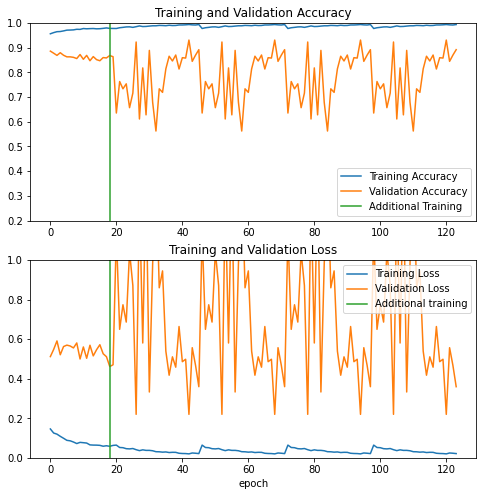

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Additional Training')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Additional training')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
22,0.019862,0.993428,0.999889,0.993536,0.993209,0.219769,0.930610,0.986497,0.932873,0.930118,0.000032
6,0.041002,0.984775,0.999172,0.985310,0.984447,0.219885,0.922736,0.985891,0.924370,0.920276,0.000100
10,0.037606,0.987185,0.999434,0.987504,0.986747,0.332951,0.888780,0.971218,0.891919,0.885335,0.000100
25,0.021314,0.993428,0.999786,0.993426,0.993100,0.359746,0.891732,0.970852,0.892505,0.890748,0.000032
16,0.026655,0.990580,0.999588,0.990905,0.990471,0.417784,0.865157,0.959058,0.867296,0.858760,0.000100
18,0.027565,0.989704,0.999541,0.989920,0.989595,0.458399,0.870079,0.959212,0.872214,0.866634,0.000032
24,0.023086,0.991566,0.999689,0.991999,0.991347,0.468089,0.869587,0.959662,0.870920,0.866634,0.000032
20,0.021803,0.991676,0.999862,0.991783,0.991457,0.486191,0.859252,0.955679,0.860465,0.855807,0.000032
21,0.021401,0.992333,0.999790,0.992442,0.992333,0.498593,0.857776,0.954277,0.861386,0.856299,0.000032


In [16]:
history_finetune2 = chexnet_model.fit(train_generator,
                            epochs=55,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                             callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  3.1622774e-05
Epoch 45/55
286/286 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9927 - AUC: 0.9999 - precision: 0.9928 - recall: 0.9923
Epoch 00045: val_loss did not improve from 0.21977
End of epoch 44. Learning rate: 3.1622774e-05
286/286 [==============================] - 123s 407ms/step - loss: 0.0211 - accuracy: 0.9927 - AUC: 0.9999 - precision: 0.9928 - recall: 0.9923 - val_loss: 0.3809 - val_accuracy: 0.8858 - val_AUC: 0.9690 - val_precision: 0.8865 - val_recall: 0.8844 - lr: 3.1623e-05
Learning rate:  3.1622774e-05
Epoch 46/55
286/286 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9915 - AUC: 0.9997 - precision: 0.9916 - recall: 0.9912
Epoch 00046: val_loss did not improve from 0.21977
End of epoch 45. Learning rate: 3.1622774e-05
286/286 [==============================] - 116s 404ms/step - loss: 0.0232 - accuracy: 0.9915 - AUC: 0.9997 - precision: 0.9916 - recall: 0.9912 - val_loss: 0.5170 - 

In [17]:
hist_df = pd.DataFrame(history_finetune2.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
0,0.021107,0.992662,0.999870,0.992768,0.992333,0.380921,0.885827,0.969042,0.886532,0.884350,0.000032
3,0.021093,0.992223,0.999870,0.992223,0.992114,0.428226,0.871555,0.962947,0.874195,0.868602,0.000032
8,0.020463,0.993209,0.999664,0.993317,0.992990,0.430951,0.872047,0.963225,0.876549,0.870079,0.000032
1,0.023193,0.991457,0.999686,0.991563,0.991238,0.517000,0.848425,0.950380,0.851741,0.842520,0.000032
10,0.023347,0.991785,0.999521,0.991999,0.991347,0.586614,0.839567,0.944515,0.843254,0.836614,0.000032
7,0.018467,0.993209,0.999901,0.993425,0.992990,0.613151,0.825295,0.939617,0.828954,0.822835,0.000032
4,0.021981,0.992004,0.999623,0.992439,0.992004,0.629591,0.815945,0.934323,0.819762,0.812500,0.000032
2,0.019123,0.993319,0.999758,0.993426,0.993100,0.654366,0.814961,0.931014,0.820309,0.811024,0.000032
5,0.019718,0.994304,0.999790,0.994304,0.994195,0.856306,0.770669,0.907407,0.774515,0.765748,0.000032


### Model Evaluation

#### Montgomery County dataset

In [ ]:
TEST_IMAGE_FOLDER = '/home/TBX11K/BF/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

model = tf.keras.models.load_model('./weights/chexnet_bf.hdf5')
res = model.predict(test_generator)

In [ ]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

#### Shenzhen Evaluation

In [ ]:
TEST_IMAGE_FOLDER = '/home/TBX11K/BF/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

In [ ]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)